In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define directories
PROCESSED_DATA_DIR = '../data/processed_data/'
VISUALIZATION_DIR = '../visualizations/'
os.makedirs(VISUALIZATION_DIR, exist_ok=True) # Ensure viz dir exists

# Load the preprocessed data
preprocessed_file_path = os.path.join(PROCESSED_DATA_DIR, 'nasa_battery_data_preprocessed.csv')

try:
    df_eda = pd.read_csv(preprocessed_file_path)
    print("Successfully loaded preprocessed data.")
    df_eda.info()
except FileNotFoundError:
    print(f"Error: File not found at {preprocessed_file_path}")
    df_eda = None
except Exception as e:
    print(f"Error loading CSV: {e}")
    df_eda = None

# Set plot style
sns.set_theme(style="whitegrid")

Successfully loaded preprocessed data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497590 entries, 0 to 1497589
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   battery_id                   1497590 non-null  object 
 1   cycle_number                 1497590 non-null  int64  
 2   cycle_type                   1497590 non-null  object 
 3   ambient_temperature          1497590 non-null  int64  
 4   measurement_time_relative    1497590 non-null  float64
 5   voltage_measured             1497590 non-null  float64
 6   current_measured             1497590 non-null  float64
 7   temperature_measured         1497590 non-null  float64
 8   voltage_load_or_charge       1497590 non-null  float64
 9   current_load_or_charge       1497590 non-null  float64
 10  capacity                     135436 non-null   float64
 11  initial_capacity             1497590 non-null  float64
 12  soh

## Plot SoH Degradation Over Cycles


Plotting SoH vs Cycle Number for each battery...


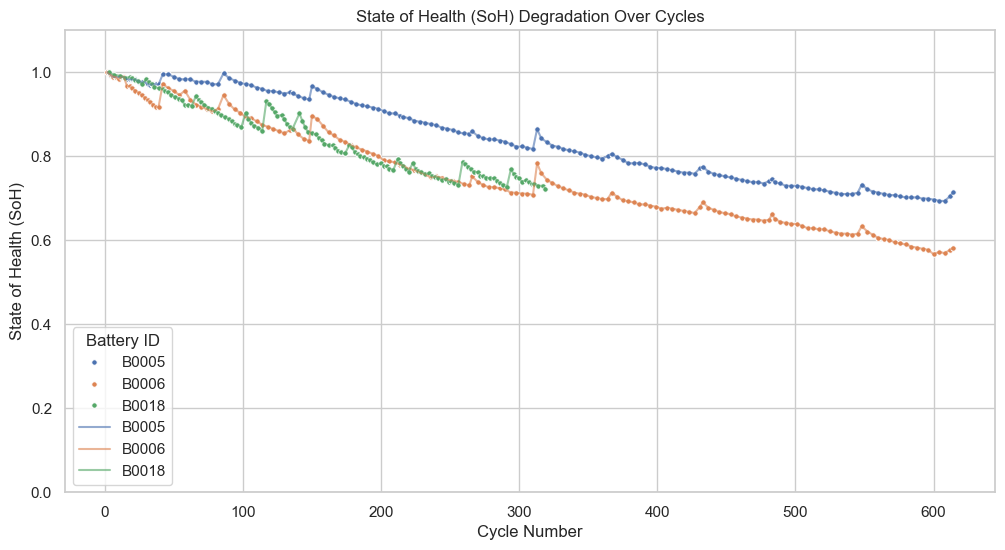

In [ ]:
if df_eda is not None:
    print("\nPlotting SoH vs Cycle Number for each battery...")

    # Get unique SoH value per cycle (since it's constant within a cycle)
    soh_per_cycle = df_eda.loc[df_eda['soh'].notna(), ['battery_id', 'cycle_number', 'soh']].drop_duplicates()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=soh_per_cycle, x='cycle_number', y='soh', hue='battery_id', marker='o', markersize=4, linestyle='') # Use markers only initially
    sns.lineplot(data=soh_per_cycle, x='cycle_number', y='soh', hue='battery_id', alpha=0.6) # Overlay lines

    plt.title('State of Health (SoH) Degradation Over Cycles')
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SoH)')
    plt.ylim(0, 1.1) # Set y-axis limit for better view
    plt.grid(True)
    plt.legend(title='Battery ID')

    # Save the plot
    plot_filename = os.path.join(VISUALIZATION_DIR, 'soh_vs_cycle.png')
    plt.savefig(plot_filename)
    plt.show()

## Prepare Data for Cycle-Level Correlation

In [3]:
if df_eda is not None:
    print("\nAggregating data for cycle-level analysis...")

    # Select only discharge cycles for meaningful capacity/SoH comparison
    df_discharge = df_eda[df_eda['cycle_type'] == 'discharge'].copy()

    # Aggregate features per cycle
    cycle_agg = df_discharge.groupby(['battery_id', 'cycle_number']).agg(
        soh=('soh', 'first'), # SoH is constant within cycle
        avg_voltage_measured=('voltage_measured_smooth', 'mean'),
        avg_current_measured=('current_measured_smooth', 'mean'), # Avg discharge current should be ~ -2A
        avg_temp_measured=('temperature_measured_smooth', 'mean'),
        max_temp_measured=('temperature_measured_smooth', 'max'),
        delta_temp_measured=('temperature_measured_smooth', lambda x: x.max() - x.min()), # Temp rise during discharge
        discharge_time_s=('measurement_time_relative', 'max') # Duration of discharge step
        # Add other aggregations if needed (e.g., min voltage, variance, etc.)
    ).reset_index()

    print("Cycle-level aggregated data created:")
    display(cycle_agg.head())
    cycle_agg.info()


Aggregating data for cycle-level analysis...
Cycle-level aggregated data created:


,battery_id,cycle_number,soh,avg_voltage_measured,avg_current_measured,avg_temp_measured,max_temp_measured,delta_temp_measured,discharge_time_s
0,B0005,2,1.000000,3.529931,-1.817567,32.572548,38.811149,14.560156,3690.234
1,B0005,4,0.994527,3.537422,-1.816408,32.725449,38.850814,14.237473,3672.344
2,B0005,6,0.988614,3.543837,-1.815331,32.643078,38.660226,13.999432,3651.641
3,B0005,8,0.988567,3.543768,-1.824434,32.515104,38.584099,14.009088,3631.563
4,B0005,10,0.988235,3.542445,-1.824961,32.382569,38.477665,14.029403,3629.172


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   battery_id            468 non-null    object 
 1   cycle_number          468 non-null    int64  
 2   soh                   468 non-null    float64
 3   avg_voltage_measured  468 non-null    float64
 4   avg_current_measured  468 non-null    float64
 5   avg_temp_measured     468 non-null    float64
 6   max_temp_measured     468 non-null    float64
 7   delta_temp_measured   468 non-null    float64
 8   discharge_time_s      468 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 33.0+ KB


## Correlation Analysis (Cycle Level)


Calculating and plotting correlation matrix...


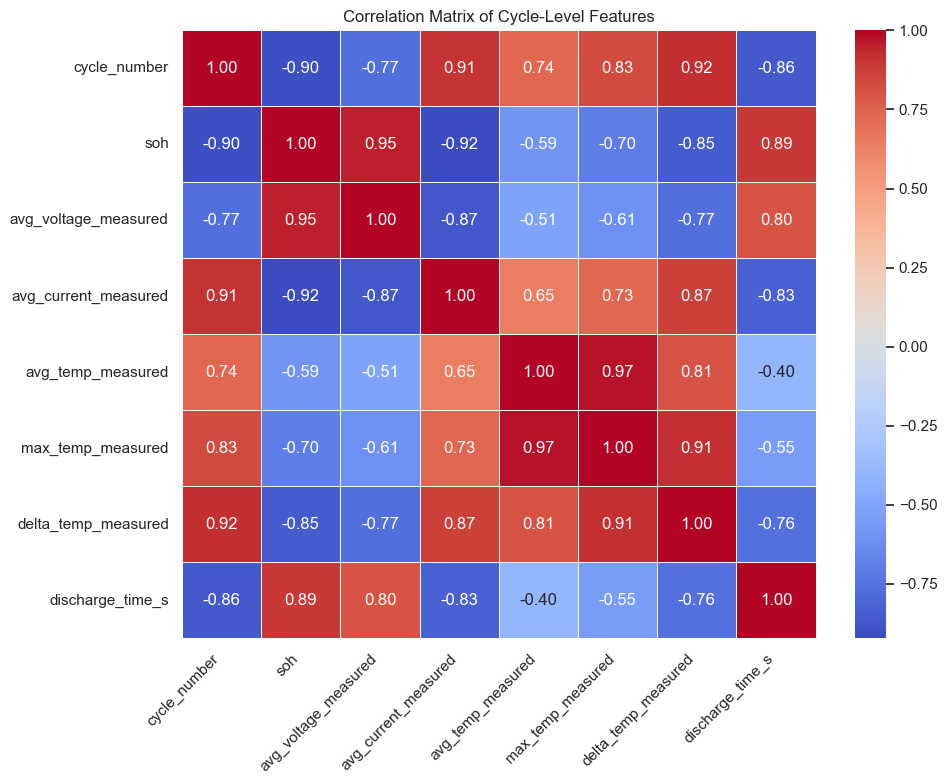


Correlations with SoH:
soh                     1.000000
avg_voltage_measured    0.951158
discharge_time_s        0.893596
avg_temp_measured      -0.585927
max_temp_measured      -0.704020
delta_temp_measured    -0.854352
cycle_number           -0.902096
avg_current_measured   -0.922579
Name: soh, dtype: float64


In [ ]:
if 'cycle_agg' in locals() and not cycle_agg.empty:
    print("\nCalculating and plotting correlation matrix...")

    # Select numerical columns for correlation
    correlation_cols = ['cycle_number', 'soh', 'avg_voltage_measured', 'avg_current_measured',
                        'avg_temp_measured', 'max_temp_measured', 'delta_temp_measured', 'discharge_time_s']
    correlation_matrix = cycle_agg[correlation_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Cycle-Level Features')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot
    plot_filename = os.path.join(VISUALIZATION_DIR, 'cycle_level_correlation_heatmap.png')
    plt.savefig(plot_filename)
    plt.show()

    print("\nCorrelations with SoH:")
    print(correlation_matrix['soh'].sort_values(ascending=False))

### Interpretation & Implications for Modeling

**Correlation Matrix & Correlations with SoH:**

This is highly informative for feature selection:

*   **`soh` vs `cycle_number` (-0.90):** Very strong negative correlation, as expected. As cycles increase, health decreases.
*   **`soh` vs `avg_voltage_measured` (+0.95):** Extremely strong positive correlation. This suggests that as the battery degrades, the *average* voltage during discharge decreases significantly. This is a very promising predictor.
*   **`soh` vs `discharge_time_s` (+0.89):** Very strong positive correlation. Healthy batteries take longer to discharge at the same current. As SoH drops, the time it takes to reach the cutoff voltage decreases. Another excellent potential predictor.
*   **`soh` vs `avg_current_measured` (-0.92):** Very strong negative correlation. This might seem counter-intuitive at first. However, looking at the `cycle_agg` head, `avg_current_measured` is around -1.8A, slightly less negative than the nominal -2.0A discharge. This correlation suggests that *less healthy* batteries might maintain an average current *closer* to the nominal -2.0A (less deviation), or perhaps the deviation pattern changes. This needs careful consideration but is clearly a strong indicator. *Correction/Refinement:* More likely, this strong correlation reflects that subtle changes in the actual average current drawn during the "constant current" phase are linked to degradation, perhaps due to resistance changes.
*   **`soh` vs `delta_temp_measured` (-0.85):** Strong negative correlation. Healthier batteries experience a smaller temperature *rise* during discharge compared to degraded batteries (which likely have higher internal resistance, generating more heat). Very useful feature.
*   **`soh` vs `max_temp_measured` (-0.70):** Moderately strong negative correlation. Degraded batteries reach higher peak temperatures during discharge.
*   **`soh` vs `avg_temp_measured` (-0.59):** Moderate negative correlation. Degraded batteries tend to have a higher average temperature during discharge.

**Multicollinearity:**

*   There are strong correlations between some potential predictor variables:
    *   `cycle_number` is strongly correlated with almost everything (as expected, since most things change over the battery's life).
    *   `discharge_time_s` and `avg_voltage_measured` are highly correlated (+0.80). This makes sense - a higher average voltage generally means it takes longer to discharge.
    *   Temperature features (`avg_temp`, `max_temp`, `delta_temp`) are highly correlated with each other (+0.97, +0.81). Using all three might be redundant. `delta_temp_measured` shows the strongest correlation with SoH (-0.85), making it perhaps the most promising single temperature feature from this set.
    *   `avg_current_measured` is strongly correlated with `cycle_number`, `avg_voltage_measured`, `delta_temp`, and `discharge_time`.

**Interpretation & Implications for Modeling:**

*   **Key Predictors:** `avg_voltage_measured`, `discharge_time_s`, `avg_current_measured`, and `delta_temp_measured` appear to be the strongest cycle-level predictors for SoH based on this analysis. `cycle_number` itself is also predictive but represents time rather than a direct physical measurement.
*   **Feature Selection/Engineering:**
    *   We should definitely include features derived from discharge voltage, time, and temperature rise.
    *   Using *all* highly correlated features (like all three temperature metrics, or both discharge time and average voltage) might not significantly improve some models (like linear models) due to multicollinearity, but could still be useful for others (like tree-based models or NNs).
    *   This motivates further feature engineering directly from the *shape* of the voltage/current/temperature curves within cycles, rather than just cycle averages/max/min. Techniques like ICA/DVA aim to capture shape changes.
*   **Data Quality:** The strong, physically plausible correlations increase confidence in the data quality after cleaning.


## Plot Discharge Voltage Curves at Different SoH Levels

In [7]:
df_b0005_discharge = df_eda[(df_eda['battery_id'] == 'B0005') & (df_eda['cycle_type'] == 'discharge')].copy()
print(df_b0005_discharge.cycle_number.unique())

[  2   4   6   8  10  12  14  16  18  20  22  25  27  29  31  33  35  37
  39  42  46  50  54  58  62  66  70  74  78  82  86  90  94  98 102 106
 110 114 118 122 126 130 134 136 140 144 148 150 154 158 162 166 170 174
 178 182 186 190 194 198 202 206 210 214 216 220 224 228 232 236 240 244
 248 252 256 260 264 266 270 274 278 282 286 290 294 298 302 306 310 313
 316 320 324 328 332 336 340 344 348 352 356 360 364 367 371 375 379 383
 387 391 395 399 403 407 411 415 419 423 427 431 433 437 441 445 449 453
 457 461 465 469 473 477 481 483 485 489 493 497 501 505 509 513 517 521
 525 529 533 537 541 545 548 552 556 560 564 568 572 576 580 584 588 592
 596 600 604 608 612 614]


## Plot Discharge Voltage Curves at Different SoH Levels (Corrected Cycles)


Plotting discharge voltage curves at different SoH levels (B0005)...


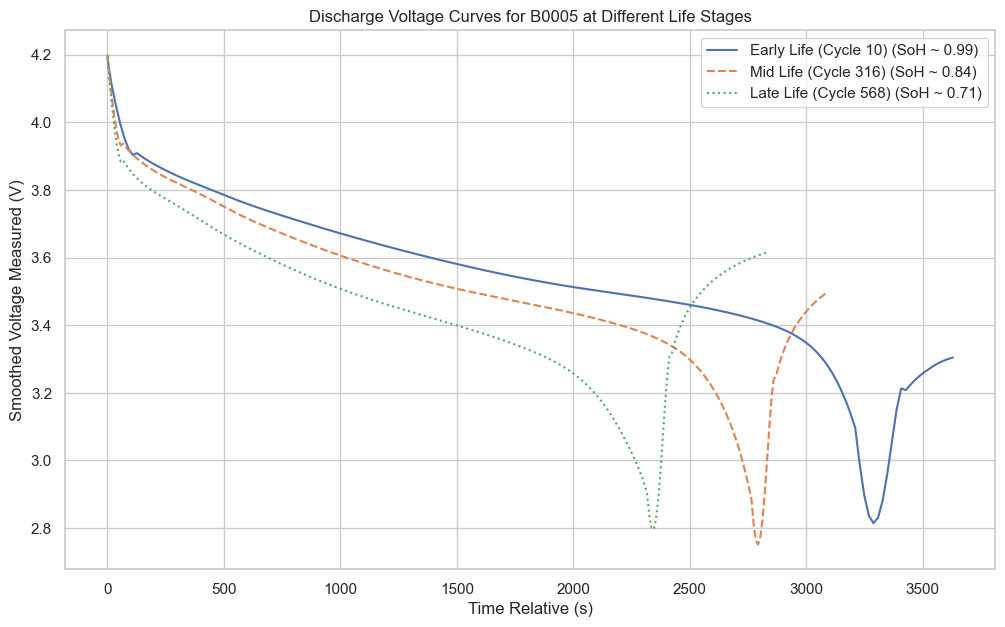

In [8]:
if df_eda is not None:
    print("\nPlotting discharge voltage curves at different SoH levels (B0005)...")

    # Select B0005 discharge data
    df_b0005_discharge = df_eda[(df_eda['battery_id'] == 'B0005') & (df_eda['cycle_type'] == 'discharge')].copy()

    # Define cycle numbers for early, mid, and late life (use known discharge cycles)
    cycles_to_plot = {
        'Early Life (Cycle 10)': 10,
        'Mid Life (Cycle 316)': 316,
        'Late Life (Cycle 568)': 568
    }

    plt.figure(figsize=(12, 7))

    line_styles = ['-', '--', ':'] # Different styles for clarity
    style_idx = 0

    for label, cycle_num in cycles_to_plot.items():
        cycle_data = df_b0005_discharge[df_b0005_discharge['cycle_number'] == cycle_num]
        if not cycle_data.empty:
            # Get SoH for this cycle to add to label
            soh_val = cycle_data['soh'].iloc[0]
            plot_label = f'{label} (SoH ~ {soh_val:.2f})'
            plt.plot(cycle_data['measurement_time_relative'],
                     cycle_data['voltage_measured_smooth'],
                     label=plot_label,
                     linestyle=line_styles[style_idx % len(line_styles)]) # Apply different line styles
            style_idx += 1
        else:
            print(f"Warning: Could not find data for discharge cycle {cycle_num}")

    plt.title('Discharge Voltage Curves for B0005 at Different Life Stages')
    plt.xlabel('Time Relative (s)')
    plt.ylabel('Smoothed Voltage Measured (V)')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = os.path.join(VISUALIZATION_DIR, 'discharge_voltage_curves_comparison.png')
    plt.savefig(plot_filename)
    plt.show()

## Merge Cycle-Level Features back to Main DataFrame

In [9]:
if df_eda is not None and 'cycle_agg' in locals() and not cycle_agg.empty:
    print("\nMerging cycle-level aggregated features (discharge_time_s, delta_temp_measured) back...")

    # Select the columns to merge from cycle_agg
    features_to_merge = cycle_agg[['battery_id', 'cycle_number', 'discharge_time_s', 'delta_temp_measured']]

    # Perform a left merge - keep all rows from df_eda, add matching features from cycle_agg
    # This will add the features only to rows corresponding to discharge cycles
    df_eda = pd.merge(
        df_eda,
        features_to_merge,
        on=['battery_id', 'cycle_number'],
        how='left'
    )

    print("Merge complete.")
    print("\nChecking merged columns (showing rows from a discharge cycle):")
    # Display head of a discharge cycle to see the new columns populated
    display(df_eda[(df_eda['battery_id']=='B0005') & (df_eda['cycle_number']==2)].head())

    # Check how many rows have the new features (should match discharge rows)
    print(f"\nNon-null count for 'discharge_time_s': {df_eda['discharge_time_s'].notna().sum()}")
    print(f"Non-null count for 'delta_temp_measured': {df_eda['delta_temp_measured'].notna().sum()}")

    # For charge cycles, these columns will have NaN. We might fill them later if needed,
    # but often they are only relevant for discharge-based features.
    print("\nExample of merged columns for a charge cycle (should be NaN):")
    display(df_eda[(df_eda['battery_id']=='B0005') & (df_eda['cycle_number']==1)].head())


Merging cycle-level aggregated features (discharge_time_s, delta_temp_measured) back...
Merge complete.

Checking merged columns (showing rows from a discharge cycle):


,battery_id,cycle_number,cycle_type,ambient_temperature,measurement_time_relative,voltage_measured,current_measured,temperature_measured,voltage_load_or_charge,current_load_or_charge,capacity,initial_capacity,soh,voltage_measured_smooth,current_measured_smooth,temperature_measured_smooth,discharge_time_s,delta_temp_measured
789,B0005,2,discharge,24,0.000,4.191492,-0.004902,24.330034,0.000,-0.0006,1.856487,1.856487,1.0,4.192535,-0.087576,24.250993,3690.234,14.560156
790,B0005,2,discharge,24,16.781,4.190749,-0.001478,24.325993,4.206,-0.0006,1.856487,1.856487,1.0,4.114549,-0.694652,24.349238,3690.234,14.560156
791,B0005,2,discharge,24,35.703,3.974871,-2.012528,24.389085,3.062,-1.9982,1.856487,1.856487,1.0,4.047333,-1.203393,24.463179,3690.234,14.560156
792,B0005,2,discharge,24,53.781,3.951717,-2.013979,24.544752,3.030,-1.9982,1.856487,1.856487,1.0,3.990886,-1.613800,24.592816,3690.234,14.560156
793,B0005,2,discharge,24,71.922,3.934352,-2.011144,24.731385,3.011,-1.9982,1.856487,1.856487,1.0,3.945208,-1.925873,24.738148,3690.234,14.560156



Non-null count for 'discharge_time_s': 135436
Non-null count for 'delta_temp_measured': 135436

Example of merged columns for a charge cycle (should be NaN):


,battery_id,cycle_number,cycle_type,ambient_temperature,measurement_time_relative,voltage_measured,current_measured,temperature_measured,voltage_load_or_charge,current_load_or_charge,capacity,initial_capacity,soh,voltage_measured_smooth,current_measured_smooth,temperature_measured_smooth,discharge_time_s,delta_temp_measured
0,B0005,1,charge,24,0.000,3.873017,-0.001201,24.655358,0.003,0.000,NaN,1.856487,NaN,3.725090,-1.459122,24.653435,NaN,NaN
1,B0005,1,charge,24,2.532,3.479394,-4.030268,24.666480,1.570,-4.036,NaN,1.856487,NaN,3.808583,-0.602013,24.666549,NaN,NaN
2,B0005,1,charge,24,5.500,4.000588,1.512731,24.675394,4.726,1.500,NaN,1.856487,NaN,3.880187,0.124619,24.679553,NaN,NaN
3,B0005,1,charge,24,8.344,4.012395,1.509063,24.693865,4.742,1.500,NaN,1.856487,NaN,3.939903,0.720772,24.692448,NaN,NaN
4,B0005,1,charge,24,11.125,4.019708,1.511318,24.705069,4.753,1.500,NaN,1.856487,NaN,3.987730,1.186448,24.705234,NaN,NaN


## Save Processed DataFrame per Battery as CSV

In [25]:
if df_eda is not None:
    print("\nSaving processed data into separate CSV files per battery...")

    output_dir = PROCESSED_DATA_DIR # Use the processed data directory

    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get unique battery IDs
    batteries = df_eda['battery_id'].unique()

    # Columns to include in the saved files (all relevant ones processed so far)
    cols_to_save = [col for col in df_eda.columns if col not in ['voltage_measured_original', 'battery_cycle']] # Exclude temporary or redundant cols


    for battery in batteries:
        print(f" Processing and saving data for {battery}...")
        df_battery = df_eda[df_eda['battery_id'] == battery][cols_to_save].copy()

        # Define filename
        filepath = os.path.join(output_dir, f'nasa_battery_data_{battery}_preprocessed.csv')

        try:
            df_battery.to_csv(filepath, index=False)
            print(f"  Saved {df_battery.shape[0]} rows to {filepath}")
        except Exception as e:
            print(f"  Error saving data for {battery}: {e}")

    print("\nFinished saving battery-specific CSV files.")

else:
    print("\nSkipping save: df_eda not found.")


Saving processed data into separate CSV files per battery...
 Processing and saving data for B0005...
  Saved 591458 rows to ../data/processed_data/nasa_battery_data_B0005_preprocessed.csv
 Processing and saving data for B0006...
  Saved 591458 rows to ../data/processed_data/nasa_battery_data_B0006_preprocessed.csv
 Processing and saving data for B0018...
  Saved 314674 rows to ../data/processed_data/nasa_battery_data_B0018_preprocessed.csv

Finished saving battery-specific CSV files.
